# Salient object detection from RGB-D Images
https://www.notion.so/rshwndsz/NNDL-Project-ef0dd4c451c341f9b981877228f6541e

## Setup

In [ ]:
%matplotlib inline

### Downloads

In [ ]:
%%shell
pip install -U git+https://github.com/albumentations-team/albumentations > /dev/null
pip install -U git+https://github.com/PytorchLightning/pytorch-lightning.git@master > /dev/null
pip install neptune-client neptune-notebooks > /dev/null
pip install patool > /dev/null

  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-ns0kd_i3
  Running command git clone -q https://github.com/PytorchLightning/pytorch-lightning.git /tmp/pip-req-build-p2k5v1dg


### Imports

In [ ]:
# DL
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D
import torchvision as tv
import albumentations as A
from   albumentations.pytorch import ToTensorV2
import pytorch_lightning as pl

# IP
import math
import numpy as np
from   matplotlib import colors, cm, patches, pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from   PIL import Image, ImageEnhance
from   pathlib import Path

# STL
import math
import random
import os
import logging
import tarfile
from zipfile import ZipFile
import glob
import shutil
import subprocess

# Misc
from getpass import getpass
import patoolib
import requests
from tqdm.notebook import tqdm
# https://docs.neptune.ai/integrations/pytorch_lightning.html#step-4-create-neptunelogger
from pytorch_lightning.loggers.neptune import NeptuneLogger

### Logger

In [ ]:
# Setup logger
logger = logging.getLogger('classproject')
logger.setLevel(logging.DEBUG)

# Create console handler and set level to debug
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)

# Create formatter
formatter = logging.Formatter('%(name)s - %(levelname)s - %(message)s')

# Add formatter to ch
ch.setFormatter(formatter)

# Add ch to logger
logger.addHandler(ch)

# 'Test' logger
logger.debug('debug message')
logger.info('info message')
logger.warning('warn message')
logger.error('error message')
logger.critical('critical message')

# Check versions
logger.debug(f"Torch: {torch.__version__}, "
             f"Torchvision: {tv.__version__}, "
             f"Pytorch Lightning: {pl.__version__}, "
             f"albumentations: {A.__version__}")

classproject - DEBUG - debug message
classproject - INFO - info message
classproject - WARNING - warn message
classproject - ERROR - error message
classproject - CRITICAL - critical message
classproject - DEBUG - Torch: 1.7.0+cu101, Torchvision: 0.8.1+cu101, Pytorch Lightning: 1.1.0-dev, albumentations: 0.5.1


## Utils

In [ ]:
def clip_gradient(optimizer, grad_clip):
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)


def adjust_lr(optimizer, init_lr, epoch, decay_rate=0.1, decay_epoch=30):
    decay = decay_rate ** (epoch // decay_epoch)
    for param_group in optimizer.param_groups:
        param_group['lr'] = decay*init_lr
        lr=param_group['lr']
    return lr


def log_grid(grid_logger=None, log_name="grid", fig_title="Image", fig_size=(15, 15), dpi=100, tensors=[]):
    if len(tensors[0].size()) == 4:
        tensors = [torch.hstack([t for t in tensor]) for tensor in tensors]

    assert len(tensors[0].size()) == 3

    fig  = plt.figure(figsize=fig_size, dpi=dpi)
    grid = ImageGrid(fig, 111, nrows_ncols=(1, len(tensors)), axes_pad=0.1)

    for i, tensor in enumerate(tensors):
        tensor = tensor.detach()
        tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min() + 1e-8)
        tensor = tensor.cpu().permute(1, 2, 0).numpy().squeeze()

        grid[i].imshow(tensor)
        grid[i].axis('off')

    if grid_logger is None:
        plt.show(block=False)
        plt.pause(3)
        plt.close(fig)

    elif isinstance(grid_logger, pl.loggers.neptune.NeptuneLogger):
        plt.close(fig)
        grid_logger.experiment.log_image(log_name, fig, description=fig_title)

    plt.close('all')

## Dataset

### Get data

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
drive_dataset_path = Path('/gdrive') / 'My Drive' / 'Research' / 'datasets'
local_dataset_path = Path('data')
local_dataset_path.mkdir(parents=True, exist_ok=True)

shutil.copy(drive_dataset_path / 'RGB-dDataset' / 'D3Net' / 'TrainingSet.zip', local_dataset_path)
shutil.copy(drive_dataset_path / 'RGB-dDataset' / 'D3Net' / 'TestingSet.zip' , local_dataset_path)

with ZipFile(local_dataset_path / 'TrainingSet.zip') as zf:
    zf.extractall(local_dataset_path)

with ZipFile(local_dataset_path / 'TestingSet.zip') as zf:
    zf.extractall(local_dataset_path)

### Augmentations

In [ ]:
# Several data augumentation strategies
def cv_random_flip(img, label, depth):
    flip_flag = random.randint(0, 1)
    # Left Right flip
    if flip_flag == 1:
        img   = img.transpose(Image.FLIP_LEFT_RIGHT)
        label = label.transpose(Image.FLIP_LEFT_RIGHT)
        depth = depth.transpose(Image.FLIP_LEFT_RIGHT)

    return img, label, depth


def randomCrop(image, label, depth):
    border=30
    image_width = image.size[0]
    image_height = image.size[1]
    crop_win_width = np.random.randint(image_width-border , image_width)
    crop_win_height = np.random.randint(image_height-border , image_height)
    random_region = (
        (image_width - crop_win_width) >> 1, (image_height - crop_win_height) >> 1, (image_width + crop_win_width) >> 1,
        (image_height + crop_win_height) >> 1)
    return image.crop(random_region), label.crop(random_region),depth.crop(random_region)


def randomRotation(image,label,depth):
    mode=Image.BICUBIC
    if random.random()>0.8:
        random_angle = np.random.randint(-15, 15)
        image=image.rotate(random_angle, mode)
        label=label.rotate(random_angle, mode)
        depth=depth.rotate(random_angle, mode)
    return image,label,depth


def colorEnhance(image):
    bright_intensity=random.randint(5,15)/10.0
    image=ImageEnhance.Brightness(image).enhance(bright_intensity)
    contrast_intensity=random.randint(5,15)/10.0
    image=ImageEnhance.Contrast(image).enhance(contrast_intensity)
    color_intensity=random.randint(0,20)/10.0
    image=ImageEnhance.Color(image).enhance(color_intensity)
    sharp_intensity=random.randint(0,30)/10.0
    image=ImageEnhance.Sharpness(image).enhance(sharp_intensity)
    return image


def randomGaussian(image, mean=0.1, sigma=0.35):
    def gaussianNoisy(im, mean=mean, sigma=sigma):
        for _i in range(len(im)):
            im[_i] += random.gauss(mean, sigma)
        return im
    img = np.asarray(image)
    width, height = img.shape
    img = gaussianNoisy(img[:].flatten(), mean, sigma)
    img = img.reshape([width, height])
    return Image.fromarray(np.uint8(img))


def randomPeper(img):
    img      = np.array(img)
    noiseNum = int(0.0015 * img.shape[0] * img.shape[1])
    for i in range(noiseNum):
        randX = random.randint(0, img.shape[0] - 1)
        randY = random.randint(0, img.shape[1] - 1)
        if random.randint(0, 1) == 0:
            img[randX,randY] = 0
        else:
            img[randX,randY] = 255
    return Image.fromarray(img)


In [ ]:
# Dataset for training

# TODO: if time
# The current loader is not using the normalized depth maps for training and test. If you use the normalized depth maps
# (e.g., 0 represents background and 1 represents foreground.), the performance will be further improved.
class GenericSalientObjectDetectionDataset(D.Dataset):
    def __init__(self, rgb_root, gt_root, depth_root, image_size, train=True):
        self.image_size  = image_size
        self.train       = train

        if isinstance(rgb_root, str):
            self.rgb_paths   = [rgb_root + f
                                for f in os.listdir(rgb_root)
                                if f.endswith('.jpg')]
            self.gt_paths    = [gt_root + f
                                for f in os.listdir(gt_root)
                                if f.endswith('.jpg')or f.endswith('.png')]
            self.depth_paths = [depth_root + f
                                for f in os.listdir(depth_root)
                                if f.endswith('.bmp') or f.endswith('.png')]
        elif isinstance(rgb_root, list):
            for rr, gr, dr in zip(rgb_root, gt_root, depth_root):
                self.rgb_paths   = [rr + f
                                    for f in os.listdir(rr)
                                    if f.endswith('.jpg')]
                self.gt_paths    = [gr + f
                                    for f in os.listdir(gr)
                                    if f.endswith('.jpg')or f.endswith('.png')]
                self.depth_paths = [dr + f
                                    for f in os.listdir(dr)
                                    if f.endswith('.bmp') or f.endswith('.png')]

        self.rgb_paths   = sorted(self.rgb_paths)
        self.gt_paths    = sorted(self.gt_paths)
        self.depth_paths = sorted(self.depth_paths)

        self.rgb_transform = tv.transforms.Compose([
            tv.transforms.Resize((self.image_size, self.image_size)),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
        self.gt_transform = tv.transforms.Compose([
            tv.transforms.Resize((self.image_size, self.image_size)),
            tv.transforms.ToTensor(),
        ])
        self.depth_transform = tv.transforms.Compose([
            tv.transforms.Resize((self.image_size, self.image_size)),
            tv.transforms.ToTensor(),
        ])
        self.rgb_for_post_transform = tv.transforms.Compose([
            tv.transforms.Resize((self.image_size, self.image_size)),
            tv.transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.rgb_paths)

    def __getitem__(self, index):
        # Load images
        rgb   = Image.open(self.rgb_paths[index]).convert('RGB')
        gt    = Image.open(self.gt_paths[index]).convert('L')
        depth = Image.open(self.depth_paths[index]).convert('L')

        # Augmentation
        if self.train:
            rgb, gt, depth = cv_random_flip(rgb, gt, depth)
            rgb, gt, depth = randomCrop(rgb, gt, depth)
            rgb, gt, depth = randomRotation(rgb, gt, depth)
            rgb            = colorEnhance(rgb)
            gt             = randomPeper(gt)

        rgb   = self.rgb_transform(rgb)
        gt    = self.gt_transform(gt)
        depth = self.depth_transform(depth)

        if self.train:
            return rgb, gt, depth
        else:
            rgb_for_post = Image.open(self.rgb_paths[index]).convert('RGB')
            rgb_for_post = self.rgb_for_post_transform(rgb_for_post)

            fname = self.rgb_paths[index]

            return rgb, gt, depth, fname, rgb_for_post

Take the dataset on a test drive

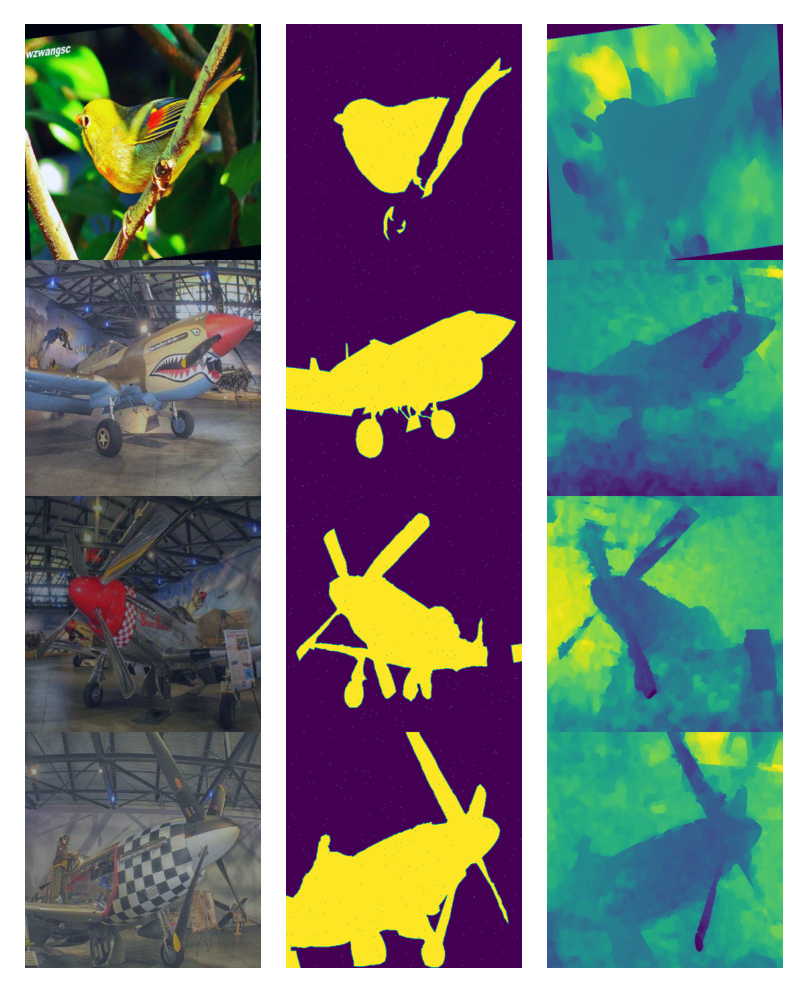

CPU times: user 768 ms, sys: 49.5 ms, total: 818 ms
Wall time: 4.78 s


In [ ]:
%%time

ds = GenericSalientObjectDetectionDataset(
    rgb_root=['/content/data/TrainingSet/NLPR_TRAIN/RGB/', '/content/data/TrainingSet/NJU2K_TRAIN/RGB/'],
    gt_root=['/content/data/TrainingSet/NLPR_TRAIN/GT/', '/content/data/TrainingSet/NJU2K_TRAIN/GT/'],
    depth_root=['/content/data/TrainingSet/NLPR_TRAIN/depth/', '/content/data/TrainingSet/NJU2K_TRAIN/depth/'],
    image_size=352,
    train=True
)
dl = D.DataLoader(dataset=ds,
                  batch_size=4,
                  shuffle=False,
                  num_workers=4,
                  pin_memory=False
                  )
batch = next(iter(dl))

# Test printing capabilities
log_grid(fig_size=(5, 5), dpi=250, tensors=batch)

## Model

### ResNet50

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet50(nn.Module):
    def __init__(self,mode='rgb'):
        self.inplanes = 64
        super(ResNet50, self).__init__()
        if(mode=='rgb'):
            self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        elif(mode=='rgbd'):
            self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        elif(mode=="share"):
            self.conv1=nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
            self.conv1_d=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        else:
            raise ValueError(f"Invalid mode {mode}")

        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(Bottleneck, 64, 3)
        self.layer2 = self._make_layer(Bottleneck, 128, 4, stride=2)
        self.layer3_1 = self._make_layer(Bottleneck, 256, 6, stride=2)
        self.layer4_1 = self._make_layer(Bottleneck, 512, 3, stride=2)

        self.inplanes = 512

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x1 = self.layer3_1(x)
        x1 = self.layer4_1(x1)

        return x1, x1

### BBSNet

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class TransBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, upsample=None, **kwargs):
        super(TransBasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, inplanes)
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.relu = nn.ReLU(inplace=True)
        if upsample is not None and stride != 1:
            self.conv2 = nn.ConvTranspose2d(inplanes, planes,
                                            kernel_size=3, stride=stride, padding=1,
                                            output_padding=1, bias=False)
        else:
            self.conv2 = conv3x3(inplanes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.upsample = upsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.upsample is not None:
            residual = self.upsample(x)

        out += residual
        out = self.relu(out)

        return out


class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()

        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1   = nn.Conv2d(in_planes, in_planes // 16, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = max_out
        return self.sigmoid(out)


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(1, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = max_out
        x = self.conv1(x)
        return self.sigmoid(x)


class BasicConv2d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes,
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, dilation=dilation, bias=False)
        self.bn = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x


class GCM(nn.Module):
    """Global Contextual module"""
    def __init__(self, in_channel, out_channel):
        super(GCM, self).__init__()
        self.relu = nn.ReLU(True)
        self.branch0 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
        )
        self.branch1 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
            BasicConv2d(out_channel, out_channel, kernel_size=(1, 3), padding=(0, 1)),
            BasicConv2d(out_channel, out_channel, kernel_size=(3, 1), padding=(1, 0)),
            BasicConv2d(out_channel, out_channel, 3, padding=3, dilation=3)
        )
        self.branch2 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
            BasicConv2d(out_channel, out_channel, kernel_size=(1, 5), padding=(0, 2)),
            BasicConv2d(out_channel, out_channel, kernel_size=(5, 1), padding=(2, 0)),
            BasicConv2d(out_channel, out_channel, 3, padding=5, dilation=5)
        )
        self.branch3 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
            BasicConv2d(out_channel, out_channel, kernel_size=(1, 7), padding=(0, 3)),
            BasicConv2d(out_channel, out_channel, kernel_size=(7, 1), padding=(3, 0)),
            BasicConv2d(out_channel, out_channel, 3, padding=7, dilation=7)
        )
        self.conv_cat = BasicConv2d(4*out_channel, out_channel, 3, padding=1)
        self.conv_res = BasicConv2d(in_channel, out_channel, 1)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)

        x_cat = self.conv_cat(torch.cat((x0, x1, x2, x3), 1))

        x = self.relu(x_cat + self.conv_res(x))
        return x


class aggregation_init(nn.Module):
    """Aggregation of the high-level(teacher) features"""
    def __init__(self, channel):
        super(aggregation_init, self).__init__()
        self.relu = nn.ReLU(True)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv_upsample1 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample2 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample3 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample4 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample5 = BasicConv2d(2*channel, 2*channel, 3, padding=1)

        self.conv_concat2 = BasicConv2d(2*channel, 2*channel, 3, padding=1)
        self.conv_concat3 = BasicConv2d(3*channel, 3*channel, 3, padding=1)
        self.conv4 = BasicConv2d(3*channel, 3*channel, 3, padding=1)
        self.conv5 = nn.Conv2d(3*channel, 1, 1)

    def forward(self, x1, x2, x3):
        x1_1 = x1
        x2_1 = self.conv_upsample1(self.upsample(x1)) * x2
        x3_1 = self.conv_upsample2(self.upsample(self.upsample(x1))) \
               * self.conv_upsample3(self.upsample(x2)) * x3

        x2_2 = torch.cat((x2_1, self.conv_upsample4(self.upsample(x1_1))), 1)
        x2_2 = self.conv_concat2(x2_2)

        x3_2 = torch.cat((x3_1, self.conv_upsample5(self.upsample(x2_2))), 1)
        x3_2 = self.conv_concat3(x3_2)

        x = self.conv4(x3_2)
        x = self.conv5(x)

        return x


class aggregation_final(nn.Module):
    """Aggregation of the low-level(student) features"""
    def __init__(self, channel):
        super(aggregation_final, self).__init__()
        self.relu = nn.ReLU(True)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv_upsample1 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample2 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample3 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample4 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample5 = BasicConv2d(2*channel, 2*channel, 3, padding=1)

        self.conv_concat2 = BasicConv2d(2*channel, 2*channel, 3, padding=1)
        self.conv_concat3 = BasicConv2d(3*channel, 3*channel, 3, padding=1)

    def forward(self, x1, x2, x3):
        x1_1 = x1
        x2_1 = self.conv_upsample1(self.upsample(x1)) * x2
        x3_1 = self.conv_upsample2(self.upsample(x1)) \
               * self.conv_upsample3(x2) * x3

        x2_2 = torch.cat((x2_1, self.conv_upsample4(self.upsample(x1_1))), 1)
        x2_2 = self.conv_concat2(x2_2)

        x3_2 = torch.cat((x3_1, self.conv_upsample5(x2_2)), 1)
        x3_2 = self.conv_concat3(x3_2)

        return x3_2


class Refine(nn.Module):
    """Refinement Flow"""
    def __init__(self):
        super(Refine,self).__init__()
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, attention,x1,x2,x3):
        # Note that there is an error in the manuscript.
        # In the paper, the refinement strategy is depicted as ""f'=f*S1""
        # it should be ""f'=f+f*S1"".
        x1 = x1 + torch.mul(x1, self.upsample2(attention))
        x2 = x2 + torch.mul(x2,self.upsample2(attention))
        x3 = x3 + torch.mul(x3,attention)

        return x1,x2,x3


class BBSNet(nn.Module):
    def __init__(self, channel=32):
        super(BBSNet, self).__init__()

        # Backbone model
        self.resnet = ResNet50('rgb')
        self.resnet_depth=ResNet50('rgbd')

        # Decoder 1
        self.rfb2_1 = GCM(512, channel)
        self.rfb3_1 = GCM(1024, channel)
        self.rfb4_1 = GCM(2048, channel)
        self.agg1 = aggregation_init(channel)

        # Decoder 2
        self.rfb0_2 = GCM(64, channel)
        self.rfb1_2 = GCM(256, channel)
        self.rfb5_2 = GCM(512, channel)
        self.agg2 = aggregation_final(channel)

        # Upsample function
        self.upsample = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)
        self.upsample4 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Refinement flow
        self.HA = Refine()

        # Components of DEM module
        self.atten_depth_channel_0 = ChannelAttention(64)
        self.atten_depth_channel_1 = ChannelAttention(256)
        self.atten_depth_channel_2 = ChannelAttention(512)
        self.atten_depth_channel_3_1 = ChannelAttention(1024)
        self.atten_depth_channel_4_1 = ChannelAttention(2048)

        self.atten_depth_spatial_0 = SpatialAttention()
        self.atten_depth_spatial_1 = SpatialAttention()
        self.atten_depth_spatial_2 = SpatialAttention()
        self.atten_depth_spatial_3_1 = SpatialAttention()
        self.atten_depth_spatial_4_1 = SpatialAttention()

        # Components of PTM module
        self.inplanes = 32*2
        self.deconv1 = self._make_transpose(TransBasicBlock, 32*2, 3, stride=2)
        self.inplanes =32
        self.deconv2 = self._make_transpose(TransBasicBlock, 32, 3, stride=2)
        self.agant1 = self._make_agant_layer(32*3, 32*2)
        self.agant2 = self._make_agant_layer(32*2, 32)
        self.out0_conv = nn.Conv2d(32*3, 1, kernel_size=1, stride=1, bias=True)
        self.out1_conv = nn.Conv2d(32*2, 1, kernel_size=1, stride=1, bias=True)
        self.out2_conv = nn.Conv2d(32*1, 1, kernel_size=1, stride=1, bias=True)

        if self.training:
            self.initialize_weights()

    def forward(self, x, x_depth):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x_depth = self.resnet_depth.conv1(x_depth)
        x_depth = self.resnet_depth.bn1(x_depth)
        x_depth = self.resnet_depth.relu(x_depth)
        x_depth = self.resnet_depth.maxpool(x_depth)

        # layer0 merge
        temp = x_depth.mul(self.atten_depth_channel_0(x_depth))
        temp = temp.mul(self.atten_depth_spatial_0(temp))
        x = x+temp
        # layer0 merge end

        x1 = self.resnet.layer1(x)  # 256 x 64 x 64
        x1_depth = self.resnet_depth.layer1(x_depth)

        # layer1 merge
        temp = x1_depth.mul(self.atten_depth_channel_1(x1_depth))
        temp = temp.mul(self.atten_depth_spatial_1(temp))
        x1 = x1+temp
        # layer1 merge end

        x2 = self.resnet.layer2(x1)  # 512 x 32 x 32
        x2_depth = self.resnet_depth.layer2(x1_depth)

        # layer2 merge
        temp = x2_depth.mul(self.atten_depth_channel_2(x2_depth))
        temp = temp.mul(self.atten_depth_spatial_2(temp))
        x2 = x2+temp
        # layer2 merge end

        x2_1 = x2

        x3_1 = self.resnet.layer3_1(x2_1)  # 1024 x 16 x 16
        x3_1_depth = self.resnet_depth.layer3_1(x2_depth)

        # layer3_1 merge
        temp = x3_1_depth.mul(self.atten_depth_channel_3_1(x3_1_depth))
        temp = temp.mul(self.atten_depth_spatial_3_1(temp))
        x3_1 = x3_1+temp
        # layer3_1 merge end

        x4_1 = self.resnet.layer4_1(x3_1)  # 2048 x 8 x 8
        x4_1_depth = self.resnet_depth.layer4_1(x3_1_depth)

        # layer4_1 merge
        temp = x4_1_depth.mul(self.atten_depth_channel_4_1(x4_1_depth))
        temp = temp.mul(self.atten_depth_spatial_4_1(temp))
        x4_1 = x4_1+temp
        # layer4_1 merge end

        # Produce initial saliency map by decoder1
        x2_1 = self.rfb2_1(x2_1)
        x3_1 = self.rfb3_1(x3_1)
        x4_1 = self.rfb4_1(x4_1)
        attention_map = self.agg1(x4_1, x3_1, x2_1)

        # Refine low-layer features by initial map
        x, x1, x5 = self.HA(attention_map.sigmoid(), x,x1,x2)

        # produce final saliency map by decoder2
        x0_2 = self.rfb0_2(x)
        x1_2 = self.rfb1_2(x1)
        x5_2 = self.rfb5_2(x5)
        y = self.agg2(x5_2, x1_2, x0_2) #*4

        # PTM module
        y = self.agant1(y)
        y = self.deconv1(y)
        y = self.agant2(y)
        y = self.deconv2(y)
        y = self.out2_conv(y)

        return self.upsample(attention_map), y

    def _make_agant_layer(self, inplanes, planes):
        layers = nn.Sequential(
            nn.Conv2d(inplanes, planes, kernel_size=1,
                      stride=1, padding=0, bias=False),
            nn.BatchNorm2d(planes),
            nn.ReLU(inplace=True)
        )
        return layers

    def _make_transpose(self, block, planes, blocks, stride=1):
        upsample = None
        if stride != 1:
            upsample = nn.Sequential(
                nn.ConvTranspose2d(self.inplanes, planes,
                                   kernel_size=2, stride=stride,
                                   padding=0, bias=False),
                nn.BatchNorm2d(planes),
            )
        elif self.inplanes != planes:
            upsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes),
            )

        layers = []

        for i in range(1, blocks):
            layers.append(block(self.inplanes, self.inplanes))

        layers.append(block(self.inplanes, planes, stride, upsample))
        self.inplanes = planes

        return nn.Sequential(*layers)

    def initialize_weights(self):
        """Initialize the weights"""
        res50 = tv.models.resnet50(pretrained=True)
        pretrained_dict = res50.state_dict()

        all_params = {}
        for k, v in self.resnet.state_dict().items():
            if k in pretrained_dict.keys():
                v = pretrained_dict[k]
                all_params[k] = v
            elif '_1' in k:
                name = k.split('_1')[0] + k.split('_1')[1]
                v = pretrained_dict[name]
                all_params[k] = v
            elif '_2' in k:
                name = k.split('_2')[0] + k.split('_2')[1]
                v = pretrained_dict[name]
                all_params[k] = v
        assert len(all_params.keys()) == len(self.resnet.state_dict().keys())
        self.resnet.load_state_dict(all_params)

        all_params = {}
        for k, v in self.resnet_depth.state_dict().items():
            if k=='conv1.weight':
                all_params[k]=torch.nn.init.normal_(v, mean=0, std=1)
            elif k in pretrained_dict.keys():
                v = pretrained_dict[k]
                all_params[k] = v
            elif '_1' in k:
                name = k.split('_1')[0] + k.split('_1')[1]
                v = pretrained_dict[name]
                all_params[k] = v
            elif '_2' in k:
                name = k.split('_2')[0] + k.split('_2')[1]
                v = pretrained_dict[name]
                all_params[k] = v
        assert len(all_params.keys()) == len(self.resnet_depth.state_dict().keys())
        self.resnet_depth.load_state_dict(all_params)


## Organised Code

In [ ]:
class Model(pl.LightningModule):
    def __init__(self, opt):
        super(Model, self).__init__()
        self.opt    = opt
        self.bbsnet = BBSNet()
        if self.opt.load is not None:
            logger.info("Loading saved weights...")
            self.bbsnet.load_state_dict(torch.load(self.opt.load))

    def forward(self, x, x_depth):
        return self.bbsnet(x, x_depth)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), self.opt.lr)

    def loss_function(self, s1, s2, gts):
        CE = nn.BCEWithLogitsLoss()
        return CE(s1, gts) + CE(s2, gts)

    def prepare_data(self):
        # Called on 1 GPU, once
        pass

    def setup(self, stage):
        # Called on every GPU, once
        if not os.path.exists(self.opt.save_path):
            os.makedirs(self.opt.save_path)
        logger.info("Loading data...")

    def train_dataloader(self):
        ds = GenericSalientObjectDetectionDataset(
            self.opt.train_rgb_root,
            self.opt.train_gt_root,
            self.opt.train_depth_root,
            self.opt.image_size,
            train=True
            )
        dl = D.DataLoader(dataset=ds,
                          batch_size=self.opt.batchsize,
                          shuffle=True,
                          num_workers=4,
                          pin_memory=True
                          )
        return dl

    def val_dataloader(self):
        ds = GenericSalientObjectDetectionDataset(
            self.opt.val_rgb_root,
            self.opt.val_gt_root,
            self.opt.val_depth_root,
            self.opt.image_size,
            train=False
            )
        dl = D.DataLoader(dataset=ds,
                          batch_size=self.opt.batchsize,
                          shuffle=False,
                          num_workers=4,
                          pin_memory=True
                          )
        return dl


    def training_step(self, batch, batch_idx):
        images, gts, depths = batch
        s1s, s2s = self(images, depths)
        loss   = self.loss_function(s1s, s2s, gts)
        self.logger.experiment.log_metric('step_train_loss', loss)

        # Log training inputs & outputs (last of every 50th batch) for debugging
        if (batch_idx + 1) % 50 == 0:
            log_grid(grid_logger=self.logger,
                     log_name='train_grid',
                     fig_size=(30, 30),
                     dpi=100,
                     fig_title=f'Epoch {self.current_epoch + 1} | Batch {batch_idx + 1}',
                     tensors=[images, gts, depths, s1s, s2s])

        return {'loss': loss}

    def training_epoch_end(self, outputs):
        # Clip optimizer gradients
        # See: https://github.com/DengPingFan/BBS-Net/blob/4b49312c28c1f245bb097c15c7d44aa31d16549c/BBSNet_train.py#L87
        clip_gradient(self.optimizers(), self.opt.clip)

        # Log average loss
        epoch_loss = torch.stack([output['loss'] for output in outputs]).mean()
        self.log('epoch_train_loss', epoch_loss, prog_bar=True)

        # Adjust Learning rate
        current_lr = adjust_lr(self.optimizers(), self.opt.lr, self.current_epoch,
                               self.opt.decay_rate, self.opt.decay_epoch)
        self.logger.experiment.log_metric('learning_rate', current_lr)

        # Save checkpoint
        if (self.current_epoch + 1) % 5 == 0:
            torch.save(self.state_dict(), self.opt.save_path + f'BBSNet_epoch_{self.current_epoch}.pth')
            self.logger.experiment.log_artifact(self.opt.save_path + f'BBSNet_epoch_{self.current_epoch}.pth')

    def validation_step(self, batch, batch_idx):
        images, gts, depths, names, img_for_posts = batch
        # NOTE: Normalize Ground Truth
        gts.div_(torch.max(gts) + 1e-8)

        s1s, s2s = self(images, depths)

        res = F.interpolate(s2s, size=gts.shape[-2:], mode='bilinear', align_corners=False)
        res = res.sigmoid()
        res = (res - res.min()) / (res.max() - res.min() + 1e-8)
        mae = torch.mean(torch.abs(res - gts)) / (gts.size(0) * gts.size(1))
        self.logger.experiment.log_metric('step_val_mae', mae)

        if (batch_idx + 1) % 25 == 0:
            log_grid(grid_logger=self.logger,
                    log_name='val_grid',
                    fig_title=f'Epoch {self.current_epoch + 1} | Batch {batch_idx + 1}',
                    fig_size=(15, 15),
                    dpi=200,
                    tensors=[images, gts, depths, s1s, s2s])

        return {'step_val_mae': mae}

    def validation_epoch_end(self, outputs):
        epoch_mae = torch.stack([output['step_val_mae'] for output in outputs]).mean()
        self.log('epoch_val_mae', epoch_mae, prog_bar=True)


    def test_step(self, batch, batch_idx):
        images, gts, depths, fnames, img_for_posts = batch
        # NOTE: Normalize Ground Truth
        gts.div_(torch.max(gts) + 1e-8)

        s1s, s2s = self(images, depths)

        res = F.interpolate(s2s, size=gts.shape[-2:], mode='bilinear', align_corners=False)
        res = res.sigmoid()
        res = (res - res.min()) / (res.max() - res.min() + 1e-8)
        mae = torch.mean(torch.abs(res - gts)) / (gts.size(0) * gts.size(1))

        for image, gt, depth, s1, s2 in zip(images, gts, depths, s1s, s2s):
            log_grid(grid_logger=self.logger,
                    log_name=f"test_grid_{fname.split('/')[-3]}",
                    fig_title=f'{fname} - Batch {batch_idx + 1}',
                    fig_size=(15, 15),
                    dpi=200,
                    tensors=[image, gt, depth, s1, s2])

## Training

### Config

In [ ]:
from collections import namedtuple

Option = namedtuple("Option",
                    ["lr", "batchsize", "image_size", "clip",
                     "decay_rate","decay_epoch", "load",
                     "train_rgb_root", "train_gt_root", "train_depth_root",
                     "val_rgb_root", "val_depth_root", "val_gt_root",
                     "save_path",])
options_dict = {
    "lr": 1e-4,
    "batchsize": 8,
    "image_size": 352,
    "clip": 0.5,
    "decay_rate": 0.1,
    "decay_epoch": 60,
    "load": None,

    "train_rgb_root": ['data/TrainingSet/NLPR_TRAIN/RGB/', 'data/TrainingSet/NJU2K_TRAIN/RGB/'],
    "train_depth_root": ['data/TrainingSet/NLPR_TRAIN/depth/', 'data/TrainingSet/NJU2K_TRAIN/depth/'],
    "train_gt_root": ['data/TrainingSet/NLPR_TRAIN/GT/', 'data/TrainingSet/NJU2K_TRAIN/GT/'],

    "val_rgb_root": ['data/TestingSet/NJU2K_TEST/RGB/', 'data/TestingSet/NLPR_TEST/RGB/'],
    "val_depth_root": ['data/TestingSet/NJU2K_TEST/depth/', 'data/TestingSet/NLPR_TEST/depth/'],
    "val_gt_root": ['data/TestingSet/NJU2K_TEST/GT/', 'data/TestingSet/NLPR_TEST/GT/'],

    "save_path": 'checkpoints/every-5/',
}
options = Option(**options_dict)

trainer_config = {
    'min_epochs': 10,
    'max_epochs': 200,

    'num_workers': 4,
    'use_gpu': torch.cuda.is_available(),
    'benchmark': True,
    'deterministic': False,
    'pin_memory': True,
    'precision': 32,

    # Data specific
    'limit_train_batches': 1.0,
    'limit_val_batches': 1.0,

    # Logging specific
    'num_sanity_val_steps': 0,
    'log_every_n_steps': 120,
    'check_val_every_n_epoch': 1,
    'log_gpu_memory': False,
}

### Experiment Logger

In [ ]:
DEBUG = False


if DEBUG:
    project_name = "shared/pytorch-lightning-integration"
    api_token    = "ANONYMOUS"
else:
    project_name = "rshwndsz/class-project"
    api_token    = getpass('Enter your private Neptune API token: ')
os.environ['NEPTUNE_API_TOKEN'] = api_token

# https://docs.neptune.ai/api-reference/neptune/experiments/index.html#neptune.experiments.Experiment
neptune_logger = NeptuneLogger(
    project_name    = project_name,
    api_key         = api_token,
    close_after_fit = False,
    experiment_name = "v1",
    params          = {**options_dict, **trainer_config},
    tags            = ["pytorch-lightning", "rgbd-sod"]
)

In [ ]:
%%shell
if [ "$NEPTUNE_API_TOKEN" = "ANONYMOUS" ] ; then
    echo "Enjoy debugging."
else
    neptune notebook sync --project rshwndsz/class-project /gdrive/My\ Drive/Colab\ Notebooks/nndl-class-project.ipynb
fi

### Callbacks, Model, Trainer

In [ ]:
pl.seed_everything(42)

# Callbacks
# https://pytorch-lightning.readthedocs.io/en/latest/weights_loading.html?highlight=ModelCheckpoint
from pytorch_lightning.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint(filepath='checkpoints/best/{epoch:03d}-{epoch_val_mae:.5f}',
                                   save_top_k=3,
                                   monitor='epoch_val_mae',
                                   mode='min',
                                   period=5)

# https://pytorch-lightning.readthedocs.io/en/latest/early_stopping.html
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
early_stop_callback = EarlyStopping(
   monitor='epoch_val_mae',
   min_delta=1e-5,
   patience=10,
   verbose=True,
   mode='min'
)

model  = Model(opt=options)

trainer = pl.Trainer(deterministic             = trainer_config['deterministic'],
                     benchmark                 = trainer_config['benchmark'],
                     min_epochs                = trainer_config['min_epochs'],
                     max_epochs                = trainer_config['max_epochs'],
                     num_sanity_val_steps      = trainer_config['num_sanity_val_steps'],
                     check_val_every_n_epoch   = trainer_config['check_val_every_n_epoch'],
                     gpus                      = -1 if trainer_config['use_gpu'] else 0,
                     logger                    = neptune_logger,
                     checkpoint_callback       = model_checkpoint,
                     callbacks                 = [early_stop_callback],
                     limit_train_batches       = trainer_config['limit_train_batches'],
                     limit_val_batches         = trainer_config['limit_val_batches'],
                     log_gpu_memory            = trainer_config['log_gpu_memory'],
                     precision                 = trainer_config['precision'],
                     log_every_n_steps         = trainer_config['log_every_n_steps'],
                     progress_bar_refresh_rate = 50,
                     )

### Train!

In [ ]:
logger.setLevel(logging.INFO)
trainer.fit(model)

### Post-train log

In [ ]:
# Log model summary
for chunk in [x for x in str(model).split('\n')]:
    neptune_logger.experiment.log_text('model_summary', str(chunk))

# Which GPUs where used?
gpu_list = [f'{i}:{torch.cuda.get_device_name(i)}' for i in range(torch.cuda.device_count())]
neptune_logger.experiment.log_text('GPUs used', ', '.join(gpu_list))

# Nvidia-SMI
# https://stackoverflow.com/a/4760517
nvidia_smi = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE).stdout.decode('utf-8')
for chunk in [x for x in nvidia_smi.split('\n')]:
    neptune_logger.experiment.log_text('nvidia-smi', str(chunk))

# Save last path
last_model_path = f"checkpoints/last/last_model--epoch={trainer.current_epoch}.ckpt"
trainer.save_checkpoint(last_model_path)
neptune_logger.experiment.log_artifact(last_model_path)

# Log score of the best model checkpoint
neptune_logger.experiment.set_property('best_model_score', model_checkpoint.best_model_score)

## Testing

In [ ]:
root = Path("data/TestingSet")
testsets = [
            root / "SSD",
            root / "DES",
            root / "LFSD",
            root / "SIP",
            root / "STERE",
]

In [ ]:
best_ckpts = sorted(Path('checkpoints/best').glob("*.ckpt"), reverse=True)
best_ckpts

In [ ]:
model   = model.load_from_checkpoint(str(best_ckpts[0]), opt=options)
trainer = pl.Trainer(gpus   = -1 if torch.cuda.is_available() else 0,
                     logger = neptune_logger,
                     progress_bar_refresh_rate = 50,
                     )

In [ ]:
for testset in testsets:
    ds = GenericSalientObjectDetectionDataset(
        str(testset) + "/RGB/",
        str(testset) + "/GT/",
        str(testset) + "/depth/",
        options.image_size,
        train=False
    )
    dl = D.DataLoader(
        dataset=ds,
        batch_size=options.batchsize,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    # Use best ckpt
    trainer.test(model, test_dataloaders=dl)

In [ ]:
neptune_logger.experiment.stop()